# Consumer Finance Case Study​

Dan Philps PhD CFA

In this code lab we will develop models to predict bad consumer credits for driving fair and interpretable lending decisions. We develop the models within the 5 stage Governance Framework, and explain how models can be validated, monitored and made to be fair.

The pace will be fast but feel free to experiment with the code to get a feel for the principles of best practice.


Dataset: Credit risk https://datahub.io/machine-learning/credit-g, contributed by Dr. Hans Hofmann, UCI German Credit Data. UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [1]:
# import the main packages we will need
# package for working with tabular data
import pandas as pd 
import numpy as np

# Package for charting
import matplotlib.pyplot as plt
import seaborn as sns #charts

# package for timing runtime
import time

# package for navigating the operating system
import os

In [2]:
# We may have to install SHAP, an explainable AI (XAI) package onto your machine (or your Google Colab session if you are running this notebook in Colabl)
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 5.5 MB/s 


## Github Repo
Many of the functions we use in this notebook are wrapped up in three functional classes on the FinGov repository. For students with coding background and the interest, we encourage you to review these classes and functions.

In [3]:
# Clone the FinGov repo which has key utility functions for this notebook
if os.path.exists('FinGov') == False:
  !git clone https://github.com/danphilps/FinGov

# Now import the objects from the repo
os.chdir('FinGov')
from StakeholderKPIReporting import StakeholderKPIReporting
from GovernanceUtils import GovernanceUtils
from FairnessUtils import FairnessUtils

import CFACreditUseCaseUtils


Cloning into 'FinGov'...
remote: Enumerating objects: 370, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 370 (delta 144), reused 151 (delta 94), pack-reused 137
Receiving objects: 100% (370/370), 158.48 KiB | 10.56 MiB/s, done.
Resolving deltas: 100% (220/220), done.


# Stage1. Business Case 


##Key Performance Indicators

- **Customer KPI (Fairness):** Customers are disadvantaged by false positives (FP), where a perfectly good applicant is predicted as a bad credit, so denied a loan. Precision is a measure that can be used to ensure that the false positives are consistent across various groups.

- **The lending institution KPI (Risk Management):** For proper risk management, the lender needs to reduce false negatives (FN), a bad applicant predicted as a good credit, who receives a loan then defaults. This means that model recall should be maximized, which would indicate minimal false negatives.

- **Compliance and Regulatory KPI (Fairness):** Regulatory KPIs are considered to focus on fairness (similar to the customer KPI above).



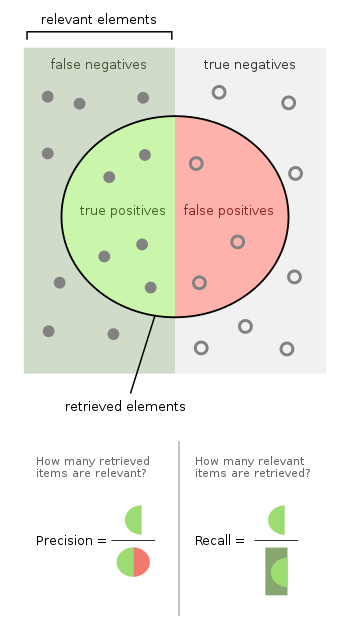
(Source: Wikipedia)



# Stage2. Data

Next we load the data we need to achieve our business aims, wrangle it and prepare it.

## Stage2a. Load Data

In [4]:
# Load the data from out GitHub repo...
loc = "data/credit-g.csv"
df_raw = pd.read_csv('https://raw.githubusercontent.com/danphilps/FinGov/main/data/credit-g.csv')

## Stage2b. Data Wrangling and Preprocessing

Data Wrangling: Convert categorical data into one-hot-encodings, clean characters from numeric data columns, carry out type conversions into numeric datatypes... all to ensure our ML can ingest and use the data we provide it with. The following cell shows the appropriate data wrangling to get our data into a good shape. 

In [5]:
# Copt raw data into our df
df = df_raw.copy(deep=True)

# list categorical columns...
cat_cols =['checking_status', 'purpose', 'credit_history', 'savings_status', 'employment', 'other_parties', 'property_magnitude', 'other_payment_plans','housing','job','own_telephone']

# One hot encoding of catagorical variables...
df[cat_cols].astype("category")
one_hot_encodings = pd.get_dummies(df[cat_cols])

#Combine dfs
df = pd.concat([df, one_hot_encodings], axis=1)

#remove categorical columns...
df = df.drop(columns=cat_cols)

#Data wrangling..... get types and bad values sorted out

# Remove characters in numeric columns (note that the data type was set, by the open_csv function to object, 
# so we first convert to string before running the replace function (which can only be fun on str types)
df['foreign_worker'] = df['foreign_worker'].str.replace('yes', '1')
df['foreign_worker'] = df['foreign_worker'].str.replace('no', '0')
df['class'] = df['class'].str.replace('good', '0')
df['class'] = df['class'].str.replace('bad', '1')

# Convert to numerics so we can use in ML... we force type conversions, then print our resulting df.
df['foreign_worker'] = pd.to_numeric(df['foreign_worker'], errors ='coerce').fillna(0).astype('int')
df['class'] = pd.to_numeric(df['class'], errors ='coerce').fillna(0).astype('int')
df['duration'] = pd.to_numeric(df['duration'], errors ='coerce').fillna(0).astype('int')
df['installment_commitment'] = pd.to_numeric(df['installment_commitment'], errors ='coerce').fillna(0).astype('int')
df['residence_since'] = pd.to_numeric(df['residence_since'], errors ='coerce').fillna(0).astype('int')
df['age'] = pd.to_numeric(df['age'], errors ='coerce').fillna(0).astype('int')
df['num_dependents'] = pd.to_numeric(df['num_dependents'], errors ='coerce').fillna(0).astype('int')

df

,duration,credit_amount,installment_commitment,personal_status,residence_since,age,existing_credits,num_dependents,foreign_worker,class,...,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes
0,6,1169,4,male single,4,67,2,1,1,0,...,0,0,1,0,0,1,0,0,0,1
1,48,5951,2,female div/dep/mar,2,22,1,1,1,1,...,0,0,1,0,0,1,0,0,1,0
2,12,2096,2,male single,3,49,1,2,1,0,...,0,0,1,0,0,0,0,1,1,0
3,42,7882,2,male single,4,45,1,2,1,0,...,0,1,0,0,0,1,0,0,1,0
4,24,4870,3,male single,4,53,2,2,1,1,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,female div/dep/mar,4,31,1,1,1,0,...,0,0,1,0,0,0,0,1,1,0
996,30,3857,4,male div/sep,4,40,1,1,1,0,...,0,0,1,0,1,0,0,0,0,1
997,12,804,4,male single,4,38,1,1,1,0,...,0,0,1,0,0,1,0,0,1,0
998,45,1845,4,male single,4,23,1,1,1,1,...,0,1,0,0,0,1,0,0,0,1


The **class** column is our classifier (ie y-variable) where 1=default, 0=no-default:

In [6]:
# our y-variable we will be fitting our classification model to
df['class']

0      0
1      1
2      0
3      0
4      1
      ..
995    0
996    0
997    0
998    1
999    0
Name: class, Length: 1000, dtype: int64

## Stage2c. Exploratory Data Analysis

Once we have loaded the data and have it in a useable form, we now need to examine it, to build an intuition for the distributions, accuracy, missing values, imbalances and so on. Examining correlations is one way we can do this.



Imbalanced data can introduce a major bias, particularly when we are fitting a model to a relatively low probability event, such as a default. 

#### Bias Alert: Imbalanced dataset

Large imbalances in datasets for classification problems are a big issue. We generally need to balance the dataset to contain a more equal proportion of the different classes before training (and testing). For the credit use-case, we have two classes {1,0}, default/no default, meaning that ideally 50% of our samples should be class=1; and 50% class=0. If this is not the case and we have an imbalance (we do), we can balance the data by up-sampling the minority class, or down-sampling the majority class.
Let us first examine the dataset to determine whether it is in balance.

Dataset Balanced?
0    700
1    300
Name: class, dtype: int64
Imbalanced y variable!


True

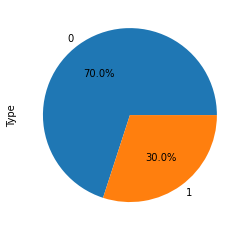

In [7]:
# Imbalanced y classes?
GovernanceUtils.imbalanced_y_check(df['class'])

The dataset is not balanced. 70% of samples are class=0; only 30% are class=1. We should bring this into balance before we train our model, or risk introducing dangerous biases into our forecasts.

#### Bias Alert: Protected and Majority Groups...

Loan approval is a high risk application. We need to go very carefully as a result. We need to identify any protected characteristics (ie it would be illegal to differentiate based on these) present in the dataset such as ethnicity and gender, where biases would be illegal. 



Having found some protected characteristics and potential biases, we need to refine the dataset to consider these. 

In [8]:
# Protected characteristics - 'personal_status' has a "gender" classifier - We need to remove this from model training.
df['gender'] = np.where(df['personal_status'].str.contains('female') == 0, 1, 0) #'male'=0; female=1
df = df.drop('personal_status', axis=1)

# Another protected characteristic is age. We can categorise the ages in our dataset... 
df['age'] = df['age'].apply(lambda x: 3 if x > 65 else (2 if x > 25 else 1))

# **********************************************************
# We need to remove these columns from model training, or risk 
# illegal biases in our outcomes... 
# Keep a record of the protected columns
protected_cols = ['gender', 'age']
# **********************************************************

# Stage3: Model Design 



## Stage 3a: Train/Test/Cross validation split

Before we choose a classifier model, we need to separate our dataset into: training data, which we will use for model fitting/training; test data, which we will use for model testing out-of-sample; and cross-validation data, which we will use for model selection.

#### Bias Alert: Data Leakage 

Separate training and testing datasets BEFORE balancing the dataset to avoid data leakage. This is crucial as our learner must not see any of the test samples until we actually test it for performance. If we fail to separate testing and training data before up samplng, we can suffer data-snooping biases (also called data-leakage), which would invalidate our model.

In [9]:
# We will use sklearn throughout this notebook
from sklearn.model_selection import train_test_split

In [10]:
# Train/Test/(and later cross-validation) datasets...
cols  = list(df.columns)
cols.remove('class')

# Contains only numerics
X = df[cols]
y = df['class']

# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Use our pre-prepared data
# Test and train set: Note that for the purposes of this demonstrationm we are using a deterministic function 
# to split the data into training and testing sets, making the results of this notebook the same every time it is run.
# DO NOT USE THIS FUNCTION IN YOUR OWN WORK.
# The sklearn train_test_split function randomly splits the training and test datasets and so can result in different outcomes.
# Note that, all else equal, the more variation in the outcomes given the test/train split, the less reliable the modeling approach.
# We leave the sklearn train_test_split commented here in case you wuold like to experiment with this feature.
use_stochastic = False 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
if use_stochastic == False:
  X_train, X_test, y_train, y_test = CFACreditUseCaseUtils.train_test_split_deterministic(X, y, test_size=0.3, random_state=None) 
else:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

#****************************
# Keep record of protected for bias testing later
X_train_protected = X_train[protected_cols]
X_test_protected = X_test[protected_cols]

# Remember to remove protected columns before training
X_train = X_train.drop(protected_cols, axis=1)
X_test = X_test.drop(protected_cols, axis=1)
#****************************

## Stage 3b: Test the performance of different up, and down sampling approaches

To balance the training data we can create more samples of the minority class (defaults), or we can downsample the majority class (non defaults). We will use a LinearDiscriminantAnalysis classifier to test how effective each approach is.

We will use the sklearn implementations of classifier models, and import them next

In [11]:
# Normalize/standardize input data
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Performance metrics...
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

First we will declare and call a wrapper function that trains and tests a  LinearDiscriminantAnalysis classifier to forecast defaults.

Note the following coding features:
- Declaration of variables with types and default values
- Sanity checking of inputs and outputs, where appropriate
- Documentation of purpose, parameters and return values, author
- Commenting throughout

<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
Accuracy train: 0.79, test:  0.75
Precision train: 0.71, test:  0.53
Recall train: 0.58, test:  0.51
F1 train: 0.64, test:  0.52


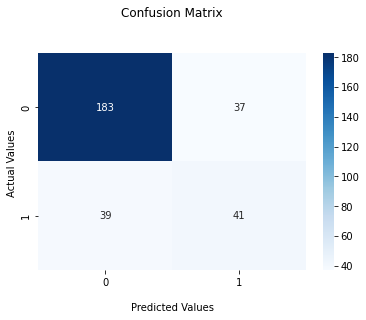

Now use sklearns predict_proba to generate probability values for each prediction


In [12]:
# Declare a function to wrap training of a classifier and printing of performance data
def run_lda_classification_models(X_train: pd.DataFrame, 
                              X_test: pd.DataFrame, 
                              y_train: pd.DataFrame, 
                              y_test: pd.DataFrame) -> object:
    
    '''
    Args:
      X_train: DataFrame with training data for classifier, columns are features, rows are instances
      X_test: Test data matching above shape
      y_train: training data target variable {1,0}, instances are rows.
      y_test: test data target variable {1,0}, instances are rows.
       
    Returns:
       rf: sklearn model object
       
    Author:
       Dan Philps
    '''

    #sanity checks on inputs
    if X_train.shape[0] != y_train.shape[0]:
      raise TypeError('Bad parameter: X_train.shape[0] != y_train.shape[0]')
    if X_test.shape[0] != y_test.shape[0]:
      raise TypeError('Bad parameter: X_train.shape[0] != y_train.shape[0]')
    if (X_train.dtypes != X_test.dtypes).sum() != 0:
      raise TypeError('Bad parameter: X_train.dtype != X_test.dtype')
    if (y_train.dtypes != y_test.dtypes):
      raise TypeError('Bad parameter: y_train.dtype != y_test.dtype')

    # Scale and transform the data for training
    X_test = GovernanceUtils.norm_X(X_train, X_test.copy(deep=True))
    X_train = GovernanceUtils.norm_X(X_train, X_train.copy(deep=True))

    # classifier train
    rf = LinearDiscriminantAnalysis()
    rf.fit(X_train,y_train)
    y_train_hat =rf.predict(X_train)
    y_test_hat = rf.predict(X_test)

    # Analytics calculated wrt default or y=1... Print score
    print(type(rf))        
    print(f"Accuracy train: {rf.score(X_train,y_train):.2f}, test: ",
      f"{rf.score(X_test,y_test):.2f}")
    print(f"Precision train: {precision_score(y_train, y_train_hat, average=None)[1]:.2f}, test: ",
      f"{precision_score(y_test,y_test_hat, average=None)[1]:.2f}")
    print(f"Recall train: {recall_score(y_train, y_train_hat, average=None)[1]:.2f}, test: ",
      f"{recall_score(y_test,y_test_hat, average=None)[1]:.2f}")
    print(f"F1 train: {f1_score(y_train, y_train_hat, average=None)[1]:.2f}, test: ",
      f"{f1_score(y_test,y_test_hat, average=None)[1]:.2f}")
    
    #Print confusion matrix...
    cf_matrix = confusion_matrix(y_test, y_test_hat, labels=[0, 1]) 
    cf_matrix_norm = cf_matrix.astype('float') # / cf_matrix.sum(axis=1)[:, np.newaxis]

    ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()

    #sanity checks on output
    if rf is None:
      raise TypeError('Bad return: rf is None')

    return rf

#run our classifier function
mod = run_lda_classification_models(X_train, X_test, y_train, y_test)

# dump the probability values for each prediction we have just made - we will be using the 
# probability value to determine the lending threshold later
print('Now use sklearns predict_proba to generate probability values for each prediction')

Note the F1 score on the test data is 0.52 using an imbalanced training 
dataset. Now we can balance the dataset.

To balance the training data we can create more samples of the minority class (defaults), or we can downsample the majority class. First we look at the performance of resampling instances fom the minority class.

### 3b i) Upsampling using resampling


In [13]:
from sklearn.utils import resample

# Split first to avoid data-snooping

# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Use our pre-prepared data
# See comments above regarding this deterministic split function.
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
if use_stochastic == False:
  X_train, X_test, y_train, y_test = CFACreditUseCaseUtils.train_test_split_deterministic(X, y, test_size=0.3, random_state=None) 
else:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

# Create up-sampled data set for minority class
# note that n_samples = the number of samples the imbalance represents.
X_upsampled, y_upsampled = resample(X_train[y_train == 1],
                                        y_train[y_train == 1],
                                        replace=True,
                                        n_samples=(X_train[y_train == 0].shape[0]-X_train[y_train == 1].shape[0]),
                                        random_state=None)

#****************************
# Keep record of protected for bias testing later
X_upsampled_protected = X_upsampled[protected_cols]
X_train_protected = X_train[protected_cols]
X_test_protected = X_test[protected_cols]

# Remember to remove protected columns before training
X_upsampled = X_upsampled.drop(protected_cols, axis=1)
X_train = X_train.drop(protected_cols, axis=1)
X_test = X_test.drop(protected_cols, axis=1)
#****************************

#Combine train with upsampled
X_upsampled = X_train.append(X_upsampled)
y_upsampled = y_train.append(y_upsampled)

Let us check everything is in balance now

Dataset Balanced?
1    479
0    479
Name: class, dtype: int64


False

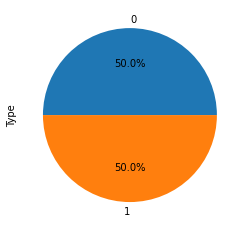

In [14]:
# Imbalanced y classes?
temp = pd.concat([X_upsampled, y_upsampled], axis=1)
GovernanceUtils.imbalanced_y_check(temp['class'])

Dataset is perfectly in balance... so we now re-run our LDA function but with a balanced dataset

<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
Accuracy train: 0.76, test:  0.69
Precision train: 0.75, test:  0.45
Recall train: 0.76, test:  0.85
F1 train: 0.76, test:  0.59


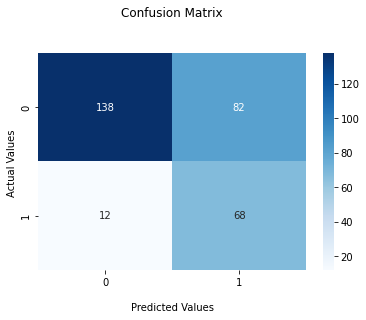

In [15]:
#Run our function....
model = run_lda_classification_models(X_upsampled, X_test, y_upsampled, y_test)

The F1 score is better than using imbalanced model

### 3b ii) Up-sampling using a synthetic over sampling approach called SMOTE

We now upsample the minorty class (defaults) by generating synthetic data using SMOTE.

In [16]:
from imblearn.over_sampling import SMOTE

# Generate SMOTE samples and use this to train
upsampler_smote = SMOTE()
X_upsampled_smote, y_upsampled_smote = upsampler_smote.fit_resample(X=X_train, y=y_train)

We examine the synthetic data (the red crosses) for similarity with the real data we are trying to sythesize...

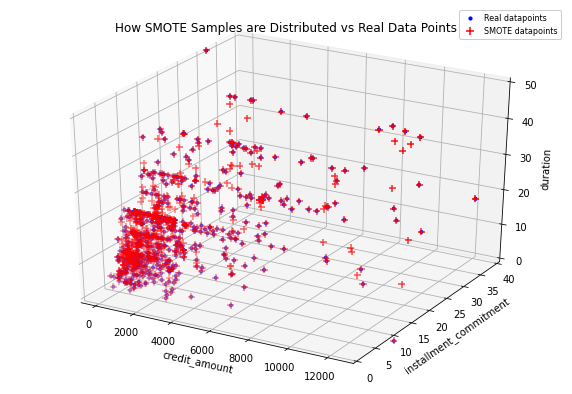

In [17]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7)) 
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train['credit_amount'],X_train['installment_commitment'], X_train['duration'], marker="o", s=10, c='blue', label='Real datapoints')
ax.scatter(X_upsampled_smote['credit_amount'],X_upsampled_smote['installment_commitment'], X_upsampled_smote['duration'], marker="+", s=50, c='red', label='SMOTE datapoints')

# set axes range
ax.set_xlim(-500, 13000)
ax.set_ylim(0, 40)
ax.set_zlim(0,50)

ax.set_xlabel('credit_amount')
ax.set_ylabel('installment_commitment')
ax.set_zlabel('duration')

plt.title('How SMOTE Samples are Distributed vs Real Data Points')
plt.legend(loc=1,framealpha=1, fontsize=8)
plt.show()

The synthetic datapoints look realistic at a glance.

Dataset Balanced?
1    479
0    479
Name: class, dtype: int64


False

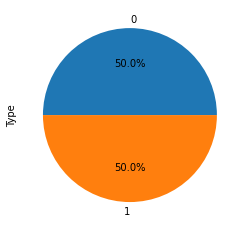

In [18]:
# Imbalanced y classes?
temp = pd.concat([X_upsampled_smote, y_upsampled_smote], axis=1)
GovernanceUtils.imbalanced_y_check(temp['class'])

Dataset is perfectly in balance... so we now re-run our LDA function but with a balanced dataset

<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
Accuracy train: 0.84, test:  0.66
Precision train: 0.87, test:  0.43
Recall train: 0.80, test:  0.79
F1 train: 0.83, test:  0.55


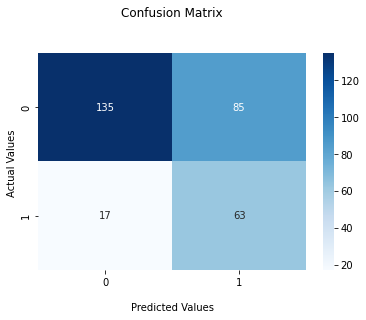

In [19]:
#Run our function....
model = run_lda_classification_models(X_upsampled_smote, X_test, y_upsampled_smote, y_test)

The F1 score is better than using imbalanced model

### 3b iii) Down-sampling - Removing rows to balance the classes

We now remove instances from the majority class to bring it into balance.

In [20]:
from imblearn.under_sampling import RandomUnderSampler 

#Split first to avoid data-snooping

# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Use our pre-prepared data
# See comments above regarding this deterministic split function.
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
if use_stochastic == False:
  X_train, X_test, y_train, y_test = CFACreditUseCaseUtils.train_test_split_deterministic(X, y, test_size=0.3, random_state=None) 
else:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

#****************************
# Keep record of protected for bias testing later
X_train_protected = X_train[protected_cols]
X_test_protected = X_test[protected_cols]

# Remember to remove protected columns before training
X_train = X_train.drop(protected_cols, axis=1)
X_test = X_test.drop(protected_cols, axis=1)
#****************************

# Randomly downsample rows in the majority class
rus = RandomUnderSampler(random_state=42)
X_downsampled, y_downsampled = rus.fit_resample(X_train, y_train)

Dataset Balanced?
0    220
1    220
Name: class, dtype: int64


False

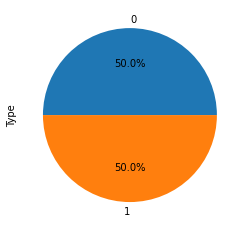

In [21]:
# Imbalanced y classes?
temp = pd.concat([X_downsampled, y_downsampled], axis=1)
GovernanceUtils.imbalanced_y_check(temp['class'])

<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
Accuracy train: 0.76, test:  0.64
Precision train: 0.75, test:  0.41
Recall train: 0.77, test:  0.74
F1 train: 0.76, test:  0.52


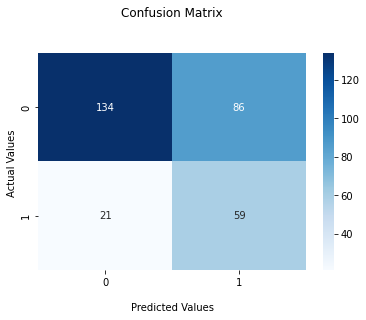

In [22]:
# Run our function to train a rf classifier....
model = run_lda_classification_models(X_downsampled, X_test, y_downsampled, y_test)

Down-sampling results in a lower F1 score than upsampling in this case, but a strategy to balance the dataset has provided as good as or better results than training the model on the imbalanmced data.

## Stage 3c: Model Selection


Next we need to select the type of classifier we are going to use to model our problem. We will separate the data into train/test/cross validation data and use the cross validation data to select the classifier we will use.

#### Bias Alert: Availability Heuristic
Model selection is open to bias. For instance, if our quant team is overpopulated by linear regression experts, we are prone to choose linear regression. If we have a greater level of familiarity for RF classifiers, we are likely to choose RF.

One way of dealing with this is to use a systematic model selection approach. We can test the problem, using many different classsifiers and assess the performance of each based on our KPIs. However, we must be careful as even this more exhaustive approach is also open to biases.


#### Bias Alert: Multiplicity bias

If we are selecting a model based on p-values, for instance, we might suffer from multiplicity bias where testing multiple approaches would exaggerate the significance of a success. 
To somewhat mitigate this we could select based on a measure such as F1-score, applied to out of sample data. In ML we tend to separate our data into training, testing, and cross-validation. We will use the cross-validation data to select a model type below.

In [44]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Use our pre-prepared files
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
if use_stochastic == False:
  # Preprepared data to demonstrate further functionality
  X_train_cv  = pd.read_csv('X_train_cv.csv')
  X_cv = pd.read_csv('X_cv.csv')
  y_train_cv = pd.read_csv('y_train_cv.csv')
  y_cv = pd.read_csv('y_cv.csv')
  X_train = pd.read_csv('X_train.csv')
  y_train = pd.read_csv('y_train.csv')
  X_test = pd.read_csv('X_test.csv')
  y_test = pd.read_csv('y_test.csv')
  X_train_protected = pd.read_csv('X_train_protected.csv')
  X_test_protected = pd.read_csv('X_test_protected.csv')

else:

  # Summary: 1) Train/test split; 2) SMOTE upsampling of training data; 3) split cross-validation set from training data
  
  # 1) Split first to avoid data-snooping
  # See comments above regarding this deterministic split function.
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

  #****************************
  # Keep record of protected for bias testing later
  X_train_protected = X_train[protected_cols]
  X_test_protected = X_test[protected_cols]

  # Remember to remove protected columns before training
  X_train = X_train.drop(protected_cols, axis=1)
  X_test = X_test.drop(protected_cols, axis=1)
  #****************************

  # 2) Split training sets into cv and train
  X_train_cv, X_cv, y_train_cv, y_cv = train_test_split(X_train, y_train, test_size=0.3, random_state=None)

  # 3) Generate SMOTE samples for train and cv sets separately.
  # SMOTE the training data... overwrite
  upsampler_smote = SMOTE()
  X_train_cv, y_train_cv = upsampler_smote.fit_resample(X=X_train_cv, y=y_train_cv)

  # SMOTE the CV data separately to avoid data snooping... overwrite
  upsampler_smote = SMOTE()
  X_cv, y_cv = upsampler_smote.fit_resample(X=X_cv, y=y_cv)



Now we call our functional class **GovernanceUtils**, and the member **auto_classifier_selection** which tests a range of classifiers from neural nets, to logistic regression to find the learner that performs best on our cross validation set. We will take the best classifier as our probability of default model.

GaussianNB()
Precision train: 0.8646, cross-validation:  0.1064
LogisticRegression(max_iter=2000, random_state=0)
Precision train: 0.8778, cross-validation:  0.5068
MLPClassifier(early_stopping=True, max_iter=2000, random_state=1)
Precision train: 0.7347, cross-validation:  0.4061
RandomForestClassifier(max_depth=3, random_state=0)
Precision train: 0.8677, cross-validation:  0.5574
LinearDiscriminantAnalysis()
Precision train: 0.8819, cross-validation:  0.4903
QuadraticDiscriminantAnalysis()
Precision train: 0.7994, cross-validation:  0.4772
AdaBoostClassifier()
Precision train: 0.8964, cross-validation:  0.0000
GradientBoostingClassifier()
Precision train: 0.9689, cross-validation:  0.3670
KNeighborsClassifier(n_neighbors=3)
Precision train: 0.8526, cross-validation:  0.0000
SVC(C=0.025, probability=True)
Precision train: 0.7347, cross-validation:  0.4734
NuSVC(probability=True)
Precision train: 0.3308, cross-validation:  0.4734

Winner
 <class 'sklearn.ensemble._forest.RandomForestCl

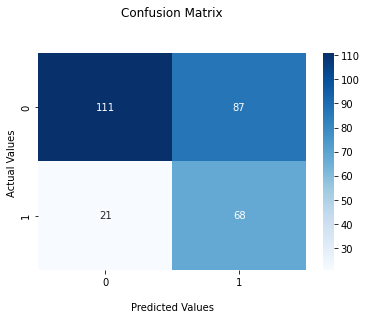

In [45]:
# Run our function....autoselect the best classifier wrt F1
max_mdl, all_models, all_models_desc, all_mdls_prec = GovernanceUtils.auto_classifier_selection(X_train=X_train_cv, 
                                                                                                X_cross_validation=X_cv, 
                                                                                                y_train=y_train_cv, 
                                                                                                y_cross_validation=y_cv, 
                                                                                                selection_criteria='f1', 
                                                                                                balance_method ='') # no balancing


You can see in the output of our function: the range of classifiers tested and test scores generated on the cross-validation test data in each case. The winner is RandomForestClassifier. And we can examine this learner's ROC curve to understand its performance.

Note that we will have a use for the other models that just missed out later, as a **challanger model**.

0.39285714285714285


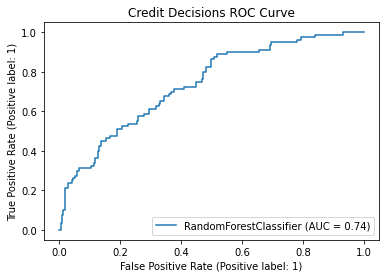

F1 score: 0.5000
Precision: 0.3929
Recall: 0.6875


In [25]:
# Predict
y_test_hat = max_mdl.predict(GovernanceUtils.norm_X(X_train_cv, X_test.copy(deep=True)).values)

# Analyst KPI...
f1, prec, rec = StakeholderKPIReporting.kpi_review_analyst(mdl=max_mdl,X=X_test, y=y_test[:].values, y_hat=y_test_hat[:])
print(f"F1 score: {f1:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")


#### Bias Alert: Inductive bias

Decision Trees, for instance, have inductive biases associated with greedy separation, whereas Random Forests (RF) mitigate this bias by using many randomized decision trees, but in turn introduce (lesser) inductive biases associated with the way an RF's underlying decision trees are constructed. One mitigant is to ensemble different learners, using a soft-max function or a voting approach. For voting based ensembling we would simply run a number of classifiers, take the majority answer: good/bad credit. The risk of not using the best performing model on our test data, and instead introducing poorer performing learners, is that we may reduce the reliance of our process on a single learner, but we could also damage our outcomes. We run such an ensemble below.
Ensembling tends to produce more robust outcomes but may in some cases damage performance.


## Stage 3d: Fairness

Next we need to use our model to forecast the probability of default of each borrower, and we now need to decide what probability of default is too high for lending. Our classsifier will forecast a default when the probability of default is >50%, but it may suit our stakeholders better to lend at higher or lower levels. 


We will execute the following steps:
- Review fairness of our model overall, regarding specific groups
- Find optimum threshold: Finally we will search for the optimum threshold, that achieves the lender KPIs best, at the same time remaining fair within our tolerances.

In [26]:
X_test_gender = pd.Series(X_test_protected['gender'].apply(lambda x: 'male' if x==1 else 'female'))

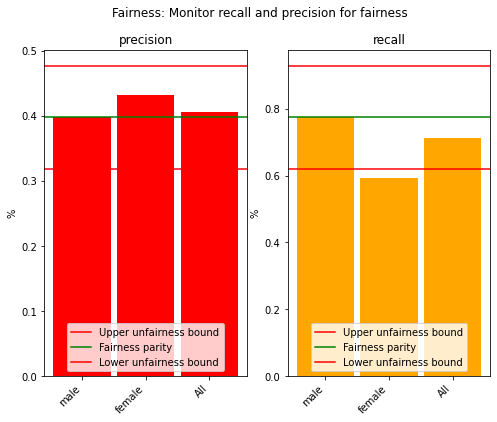

In [27]:
# Test a 0.3 threshold for fairness...
df_stats = FairnessUtils.fairness_stats_get (mod=max_mdl, 
                               X_test=X_test, 
                               y_test=y_test, 
                               X_test_category_col=X_test_gender, 
                               y_approval_threshold=0.5)

FairnessUtils.plot_fairness_charts(df_stats=df_stats, 
                                   majority_class="male", 
                                   fairness_metric="precision",
                                   threshold_metric="recall")


In this example, recall for the minority group (Female) is below the lower unfairness bound, so the model is considered “unfair”.  Lower recall for females implies higher false negatives for the minority group (i.e., loan approval, then default) vs. Males, which is why the model is deemed unfair. 
For precision, the minority group (Female) is within the unfairness bounds, so there is no issue for that metric.  


## Stage 3e: Lend at What Probability of Default?

We can optimize the lending threshold to achieve the **best recall for the lender**, at the same time as that threshold is **fair for minority groups**.

optimal_threshold = $\underset{pd \in PD}{\operatorname{argmax} 𝘧(X)}$, constrain on precision and recall for minority vs majority groups

We find the optimal_threshold for our function, 𝘧(X), by testing a range of probability of default thresholds, PD, above which we refuse credit, finding the threshold with the maximum recall, while ensuring recall and precision for females is >= 80% of the respective value for males (and similar with other minority groups).
  



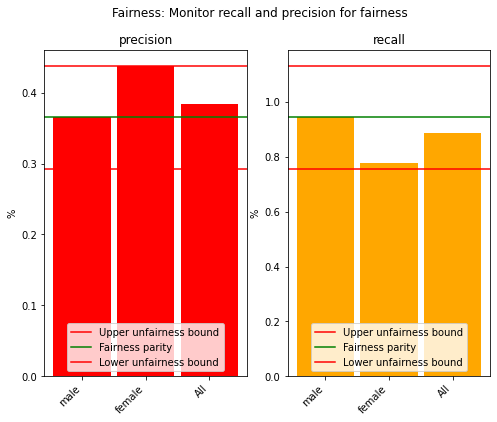

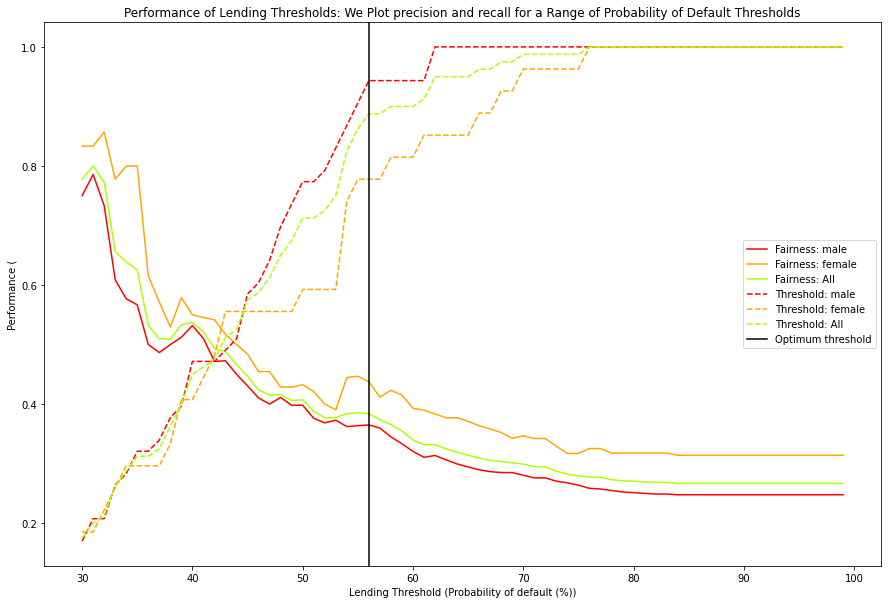

Optimal threshold: 0.56


In [28]:
# Get the optimal threhold to use, by iterating over different probability of default lending thresholds, maximizing recall and checking fairness by observing precision.
optimal_threshold = FairnessUtils.decision_threshold_find_optimal(max_mdl, 
                                                                  X_test=X_test, 
                                                                  y_test=y_test, 
                                                                  X_test_category_col=X_test_gender, 
                                                                  threshold_min_max=[40,60], 
                                                                  fairness_tolerance=0.2) 

# Approvals? Probabuility of default < optimal_threshold, is accepted.
y_approvals = max_mdl.predict_proba(GovernanceUtils.norm_X(X_train, X_test.copy(deep=True)).values)[:,1] < optimal_threshold

In [29]:
optimal_threshold

0.56

The chart above shows how our model performs in terms of recall and precision if we refuse credit at a range of default probabilities (i.e., thresholds). We test thresholds from a low of 30% probability of default to a high of 99% probability of default. You can see how the recall and the precision of the model changes overall (All), and for female and male groups for the various thresholds of default.

In this example, at the optimal_threshold, recall is maximized, and for both recall and precision, the minority group (Female) is not beyond the unfairness bounds, so there should be no fairness-related issues with this model. 


# Stage4: Model Deployment 

Deploying a model involves tiers of testing before sign off and release to the live environment, called **change control**. This involves making sure all stakeholder KPIs are satisfied and for this we can use **expainable AI (XAI)** to help explain the workings of the models to stakeholders. We now generate shap_values to explain the impact of features on our model outcomes.


In [30]:
shap_values, expl, X_test_reduced, X_test_protected_reduced = StakeholderKPIReporting.classifier_shap_vals(max_mdl=max_mdl, 
                                                                                  X_test=X_test,                                                                                      
                                                                                  X_test_protected=X_test_gender)

Permutation explainer: 26it [00:11,  1.38s/it]


## Stage4a. KPIs


### 1) Analyst and technical explainability

Analyst KPIs involve reviewing model performance, using a ROC curve, as well as consulting analytics, and examining the most important model features.


0.39285714285714285


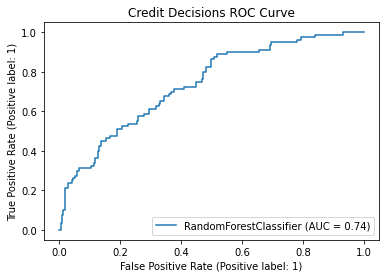

(0.5, 0.39285714285714285, 0.6875)

In [31]:
# Analyst KPI...
StakeholderKPIReporting.kpi_review_analyst(mdl=max_mdl,X=X_test, y=y_test, y_hat=y_test_hat)

We can use SHAP to plot feature importance.

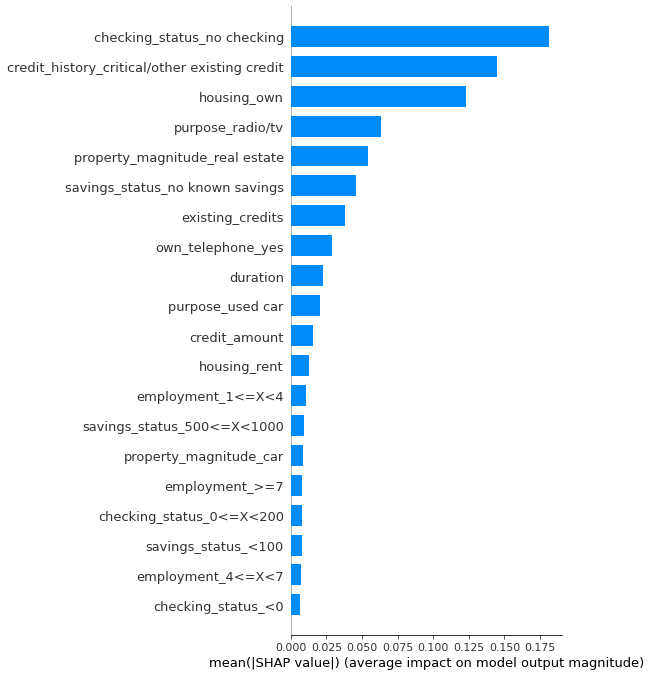

In [32]:
# Plot the feature importance
plt.set_title = "Feature Importance: Credit-Use Case Feature Importance"
shap.summary_plot(shap_values, X_test_reduced, feature_names=list(X_test_reduced.columns.values), plot_type='bar', show=False)
plt.show()

And use a SHAP Beeswarm plot to show the impact of individual instances on model outcomes, which gives us a handle on feature importance and the distribution of the impact of those features too. 

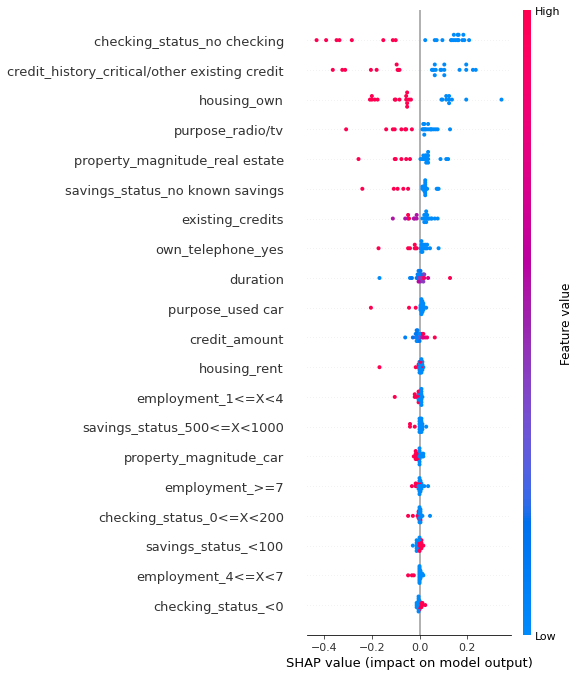

In [33]:
shap.summary_plot(shap_values, X_test_reduced, show=False)
plt.set_title = "Beeswarm: Credit-Use Case Feature Importance and Dependency"
plt.show()

### 2) Compliance and Regulatory



We can also use SHAP to detect anomalies from a Fairness standpoint too, by plotting feature importance of male and female groups side by side (for example). We would expect the feature importance for both groups to be similar, and if it is not we may have an issue.


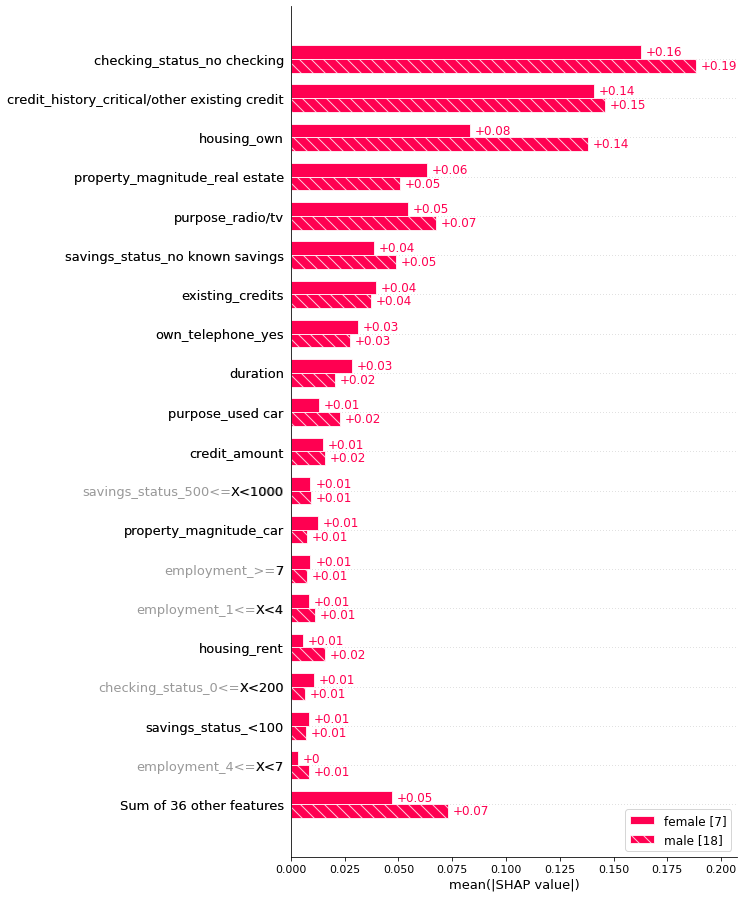

SHAP values do not allow cohort separation for <class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [34]:
# Some learners do not have direct support from shap. 
try:
  # Feature importance by protected characteristic.. different treatment?
  curr_prot_cats = X_test_protected_reduced.values 
  # Plot the feature importance
  shap.plots.bar(shap_values.cohorts(curr_prot_cats).abs.mean(0), 
                 show=True,
                 max_display=20)
  
  plt.title("Bias Check: Feature Importance of protected group: " + prot_char)
  plt.show()
except:
  print('SHAP values do not allow cohort separation for ' + str(type(max_mdl)))

You can see how this code works in Colab:

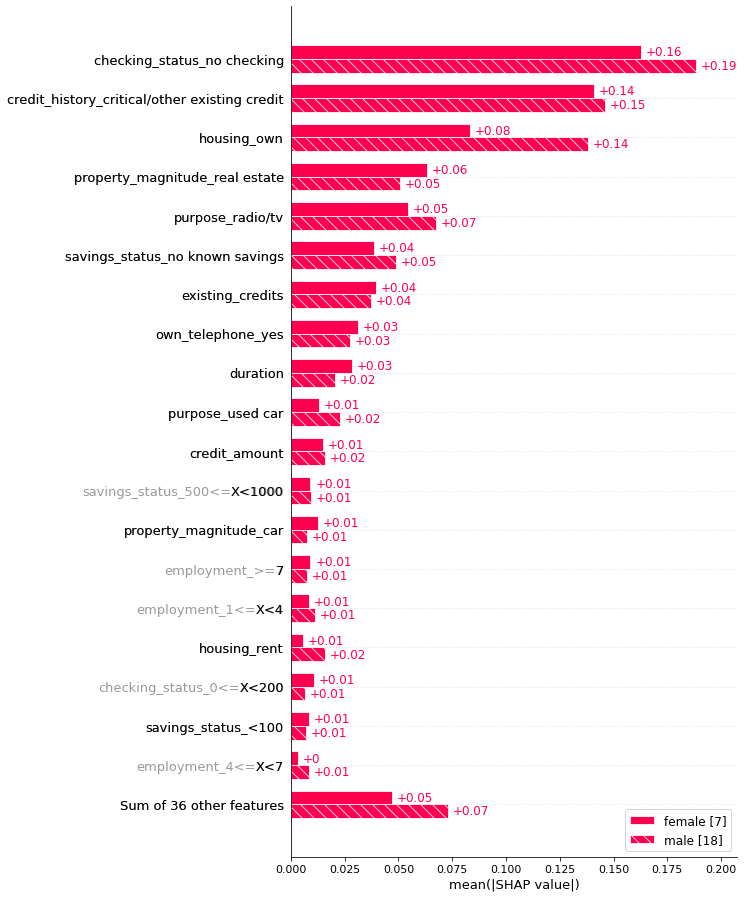

We have already reviewed the fairness of our model and the lending threshold.


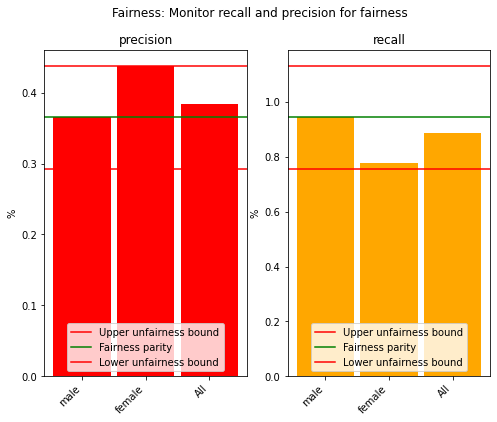

In [35]:
# Test our optimum threshold
df_stats = FairnessUtils.fairness_stats_get (mod=max_mdl, 
                               X_test=X_test, 
                               y_test=y_test, 
                               X_test_category_col=X_test_gender, 
                               y_approval_threshold=optimal_threshold)

FairnessUtils.plot_fairness_charts(df_stats=df_stats, 
                                   majority_class="male", 
                                   fairness_metric="precision",
                                   threshold_metric="recall")

### 3) Customer

A customer may want to know the reasons why credit has been refused, and we can use a SHAP waterfall plot to help understand this issue.

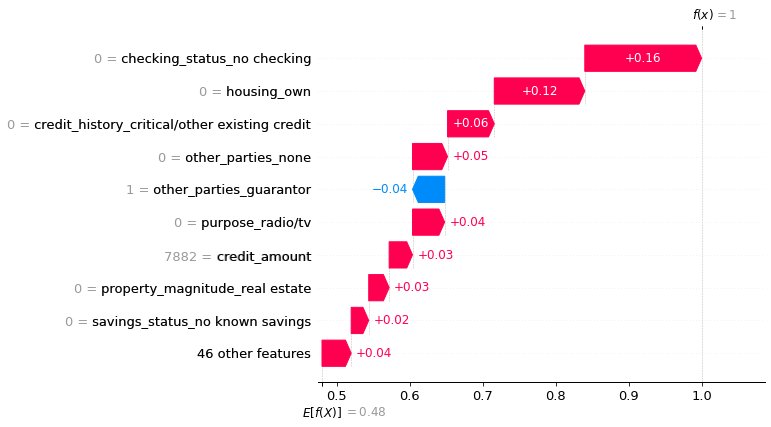

In [36]:
# Find a customer with bad credit prediction
for rejected_eg_rowno in range(0,y_test.shape[0]):
  if y_approvals[rejected_eg_rowno] == False:
    break

# This customer was refused credit and we can provide an explanation for their refusal...
try:
  shap.plots.waterfall(shap_values[rejected_eg_rowno])
except:
  print('Shap charts of this type are not supported for ' + str(type(max_mdl)))

We are able to use SHAP to drill down into a single loan application to understand why credit was refused. In this case it was down to several factors you can see above.

# Stage 5: Model Monitoring and Reporting


## Stage5a: Data Drift


Our model is now in production and being used in practice. We need to monitor its stability. One approach is to monitor the distribution of the input data versus the data the model was trained with . If the distributions have shifted the model outcomes could be invalidated. 
Here we use our function **data_drift_psi** to monitor data drift.

Is it time for us to retrain our model?


In [37]:
# Prepare train and test data for data drift check
train_datadrift = pd.concat([X_train, y_train], axis=1)
test_datadrift = pd.concat([X_test, y_test], axis=1)

# Data drift check...
data_drift_features = GovernanceUtils.data_drift_psi(train_datadrift,test_datadrift,buckettype='bins',buckets=10,axis=1,single_variable=False)
data_drift_target = data_drift_features[-1]

# Print out the target PSI value:
print("Target PSI value is ",data_drift_target, "\n" )

# Print out the features CSI values
print("The feature CSI values are:")
columns_features = train_datadrift.columns
index_value = 0
for x in columns_features:
  if data_drift_features[index_value] > 0.2:
          print(x, "*************** CSI value is over 0.2 = ",data_drift_features[index_value])
  elif data_drift_features[index_value] > 0.1:
          print(x, "*************** CSI value is over 0.1 = ",data_drift_features[index_value])
  else:
          print(x, "CSI is OK = ",data_drift_features[index_value])
  index_value = index_value + 1


The feature CSI values are:
duration *************** CSI value is over 0.1 =  0.18414116945093154
credit_amount CSI is OK =  0.09207058472546577
installment_commitment CSI is OK =  0.09207058472546577
residence_since *************** CSI value is over 0.1 =  0.18414116945093154
existing_credits CSI is OK =  0.09207058472546577
num_dependents CSI is OK =  0.09207058472546577
foreign_worker CSI is OK =  0.09207058472546577
checking_status_0<=X<200 CSI is OK =  0.09207058472546577
checking_status_<0 CSI is OK =  0.09207058472546577
checking_status_>=200 CSI is OK =  0.0
checking_status_no checking *************** CSI value is over 0.1 =  0.18414116945093154
purpose_business CSI is OK =  0.09207058472546577
purpose_domestic appliance CSI is OK =  0.09207058472546577
purpose_education *************** CSI value is over 0.1 =  0.18414116945093154
purpose_furniture/equipment *************** CSI value is over 0.1 =  0.18414116945093154
purpose_new car CSI is OK =  0.09207058472546577
purpose_oth

## Stage5b: Challenger Models

Remember that we selected a classifier based on its F1 score performance? We can use the other models that we trained at that time, to provide another check on our live model. This is called a **challenger model**.


Accuracy train: 0.6467, cross-validation:  0.6467
Precision train: 0.4071, cross-validation:  0.8562
Accuracy train: 0.7333, cross-validation:  0.7333
Precision train: 0.5000, cross-validation:  0.8684


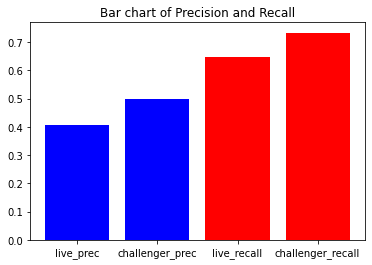

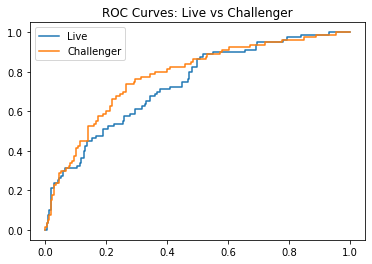

In [38]:
# Run the challenger ensemble
y_test_hat, ens_mdl = GovernanceUtils.challenger_ensemble_run(all_mdls=all_models,
                        all_mdls_desc=all_models_desc,
                        all_mdls_prec=all_mdls_prec,
                        X_train=X_train,
                        y_train=y_train,
                        X_test=X_test)

# Do we need to retrain the live model?
challenger_check_warning = GovernanceUtils.challenger_review_live(live_mod=max_mdl, challenger_mod=ens_mdl, X_test=X_test, y_test=y_test)

In [39]:
# Not we see if there are any warnings to do with the performance of our live model versus the Challenger model: 
# ... '' means ... no warnings
challenger_check_warning

''

In this case the **challenger model** is superior to our live model in terms of both recall (identifying FNs), and also precision (identifying FP). Maybe it is time for us to redevelop our model?

# Afterword

We have done our best to include the key themes of what we think are the critical stages of model development in this notebook, but clearly in practice many more checks and details would be added to each of the 5 model development stages to best ensure stakeholder's KPIs are met, and Governance standards would be as high as possible. Hopefully our example and key themes will provide insight to avoid many of the classic biases in model development.